In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import xarray
from tqdm.auto import tqdm
from ghost_xarray import open_dataarray, open_dataset

output_dir = Path("problema2/output")

## 2)
> Haciendo uso del solver ROTH en GHOST,
resuelva numéricamente la ecuación para un flujo rotante incompresible
con densidad uniforme $ρ_0 = 1$ y $ν = 3 × 10^{−3}$
en un recinto cubico de longitud lineal $2π$
y resolución espacial $N_x = N_y = N_z = 128$.
Hacer uso del Material Adicional.
Construya una perturbación inicial aleatoria $δu$ (incompresible
concentrada en una banda horizontal
con altura $2π/3$ en el centro de la caja
y nula en el resto del recinto,
con número de onda $k = 5$,
energía cinética inicial $E = ⟨u^2 /2⟩ = 1$
(donde ⟨·⟩ indica el valor medio espacial)
y sin forzado.
La resolución espacial de todas las simulaciones
será $N_x = N_y = N_z = 128$.

### (a)
> Estime en base a estos datos
qué paso temporal debería utilizar
según la condición CFL
estudiada en la Guía 1.
Estime el número de Rossby
para la condición inicial.

La condición CFL nos pide:

$$ \Delta t
< \frac{\Delta x}{U}
\sim \frac{2\pi / 128}{\sim 1} $$

In [2]:
2 * np.pi / 128

0.04908738521234052

Entonces,
necesitamos que el paso sea menor a $\sim 0.05$.

Por otro lado,
el número de Rossby $Ro$ es:

$$ Ro
= \frac{U}{L \Omega}
= \frac{\sim 1}{\sim 1 \; \Omega}
$$

donde $U$ y $L$ son la velocidad y longitud características del fenómeno,
y $f$ es la frecuencia de Coriolis.

### (b)
> Para Ω = 10,
integre el sistema hasta $t = 1$,
guardando la velocidad y la vorticidad cada $∆t = 0.05$ pasos.
Visualice la densidad de helicidad,
> $$ h(r) = u(r) · ω(r) $$
> en un corte bidimensional en el plano $x̂ − ẑ$.
¿Que ocurre con dicha cantidad a medida que el sistema evoluciona?

In [3]:
dt = 0.05


def helicity(v, w):
    return (v * w).sum(dim="i")


def load_helicity(w):
    directory = output_dir / f"w_{w}"
    data = open_dataset(
        directory,
        ["v", "w"],
        dt=dt,
        shape=(128, 128, 128),
        dtype=np.float32,
    )
    return helicity(data.v, data.w)

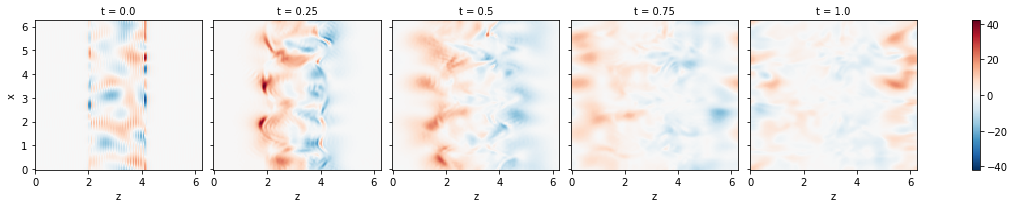

In [4]:
load_helicity(10).isel(t=slice(0, None, 5), y=64).plot(col="t")

A medida que el sismeta evoluciona,
las helicidades positivas y negativas se separan,
viajando en direcciones opuestas en $\hat{z}$.

### (c)
> Estime a qué velocidad media se propagan los paquetes
con $h > 0$ y con $h < 0$.
¿Qué velocidad espera obtener?
Compare estos resultados con una simulación no rotante, es decir, $Ω = 0$.

Podemos estimar la velocidad mirando cortes en el plano $\hat{z}-\hat{t}$,
es decir, mirando como evoluciona en el tiempo una linea en $z$,
a $x=x_0$ e $y=y_0$ constantes.

Para $\Omega=10$,
parecen moverse a velocidad constante
(franjas lineales en los planos $z$-$t$).

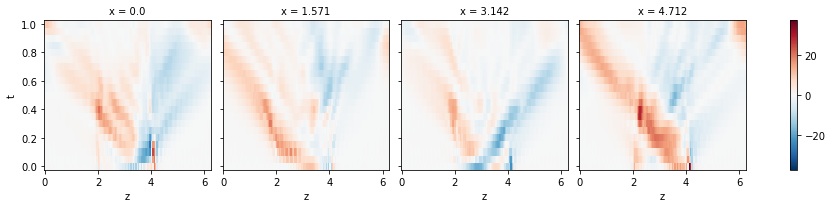

In [14]:
load_helicity(10).isel(x=slice(0, None, 32), y=64).plot(col="x")

En cambio,
para $\Omega=0$,
no se ve movimiento en la helicidad.

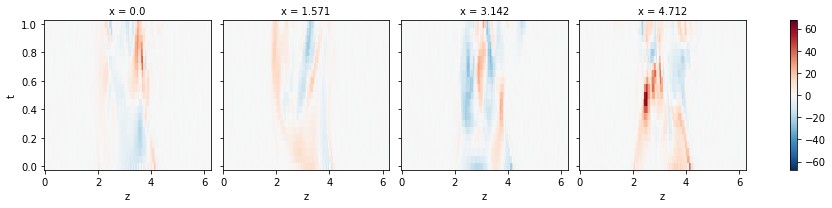

In [15]:
load_helicity(0).isel(x=slice(0, None, 32), y=64).plot(col="x")


Otra manera de estimarlo es
calcular el "centro de masa"
de las regiones con helicidad positiva (y negativa).

In [6]:
def center_of_mass(h, mask):
    """Devuelve un vector (x, y, z) con la posición del centro de masa.
    
    mask : np.ndarray[bool]
    """
    h = h.to_numpy()[mask]
    h /= h.sum()
    pos = np.where(mask)
    return xarray.DataArray([(h * p).sum() for p in pos])


def velocity(pos):
    """La norma del vector velocidad, calculado por diferencias finitas.
    
    || (x_1 - x_0) / dt ||
    """
    v = pos.diff("t")
    v = np.sqrt((v**2).sum(dim="dim_0"))
    return v


h = load_helicity(10)
pos = h.groupby("t").apply(lambda x: center_of_mass(x, x > 0))
neg = h.groupby("t").apply(lambda x: center_of_mass(x, x < 0))

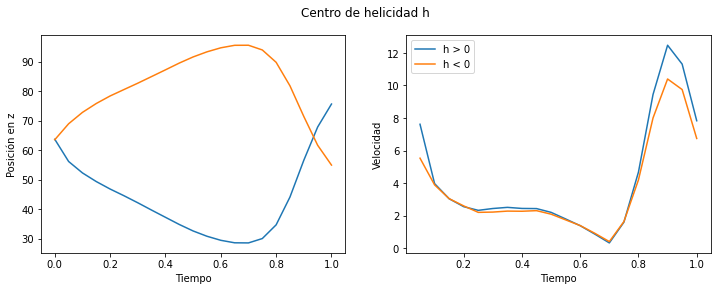

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for label, x in {"h > 0": pos, "h < 0": neg}.items():
    x[:, 2].plot(label=label, ax=ax[0])
    velocity(x).plot(label=label, ax=ax[1])

ax[0].set(ylabel="Posición en z", xlabel="Tiempo")
ax[1].set(ylabel="Velocidad", xlabel="Tiempo")
fig.suptitle("Centro de helicidad h")
for a in ax: 
    ax[1].legend()

Después de un transitorio inicial,
la helicidad en $z$ parece moverse a velocidad constante.

El cambio de dirección (y velocidad) brusco en el final
se debe a que no se está teniendo en cuenta la periodicidad en el espacio.

### (d)
> Realice simulaciones variando $Ω$ entre $0$ y $20$ (con pasos de $5$)
Grafique la velocidad media de propagación de los paquetes en función de $Ω$.

In [9]:
h_cm = {}
for w in tqdm(range(0, 21, 5)):
    h = load_helicity(w)
    pos = h.groupby("t").apply(lambda x: center_of_mass(x, x > 0))
    neg = h.groupby("t").apply(lambda x: center_of_mass(x, x < 0))
    h_cm[w] = (pos, neg)

  0%|          | 0/5 [00:00<?, ?it/s]

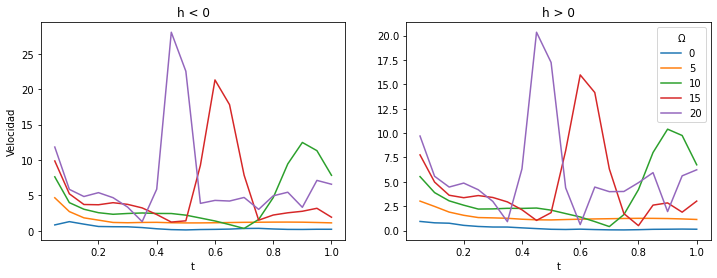

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for w, (pos, neg) in h_cm.items():
    velocity(pos).plot(label=w, ax=ax[0])
    velocity(neg).plot(label=w, ax=ax[1])

ax[0].set(title="h < 0", ylabel="Velocidad")
ax[1].set(title="h > 0")
ax[1].legend(title="$\Omega$")

A medida que aumenta la velocidad de rotación,
los paquetes se propagan a mayor velocidad media,
tanto para helicidad positiva ($h > 0$)
como negativa ($h < 0$).
De nuevo,
solo hay que mirar la sección de tiempos anterior al cambio brusco
debido a no considerar la periodicidad espacial.

In [11]:
omega, pos, neg = [], [], []
for w, (p, n) in h_cm.items():
    omega.append(w)
    pos.append(velocity(p))
    neg.append(velocity(n))

pos = xarray.concat(pos, dim=xarray.IndexVariable("omega", omega))
neg = xarray.concat(neg, dim=xarray.IndexVariable("omega", omega))

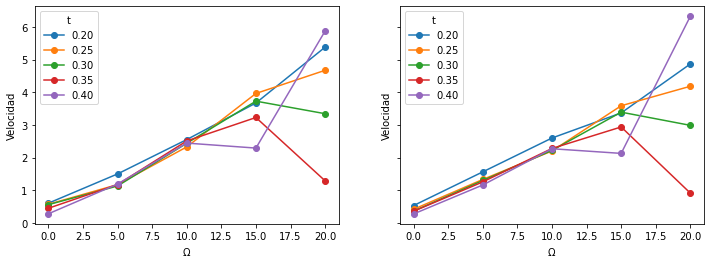

In [12]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for ax, x in zip(axes, (pos, neg)):
    x.sel(t=slice(0.2, 0.4)).plot.line(x="omega", marker="o", ax=ax, add_legend=False)
    ax.set(ylabel="Velocidad", xlabel="$\Omega$")
    ax.legend(
        [f"{xi:.2f}" for xi in x.sel(t=slice(0.2, 0.4)).t.data],
        title="t",
    )

Tomando cortes a $t=0.2$,
la velocidad crece linealmente en función de $\Omega$.

### (e)
> Para este conjunto de simulaciones,
calcule $⟨|\frac{∂u}{∂z}|⟩$ en función del tiempo
(utilice diferencias finitas para estimar la derivada espacial).
¿Que ocurre al aumentar $Ω$?

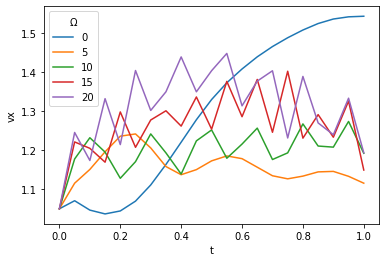

In [13]:
def load_u(w):
    return open_dataarray(
        output_dir / f"w_{w}",
        "vx",
        dt=dt,
        shape=(128, 128, 128),
        dtype=np.float32,
    )

for w in range(0, 21, 5):
    np.abs(load_u(w).differentiate("z")).mean(dim=["x", "y", "z"]).plot(label=w)
plt.legend(title="$\Omega$")

Por lo comentado en clase,
la simulación hasta este tiempo
no permite observar el comportamiento esperado.
Habría que simular hasta $t \sim 5$,
o utilizar un número de onda $k=10$.

Deberiamos haber observado que los gradientes en $\hat{z}$ tienden a $0$,
ya que el sistema tiene simetría en dicha dirección.